# Neural Style Transfer
Neural Style Transfer is essentially a way to "paint" the contents of one image using the style of another image. As a CNN learns, the feature maps in the deeper layers come to represent some high level features which can be used to create the *content representation*.

The *style representation* is created through finding correlations between features in various layers. This provides multi-scale local color and texture relations but does not provide any information globally.


In [1]:
!nvidia-smi

Sat Aug 27 04:33:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    40W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image

from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Setup Image loading and create the random noise image

Content:


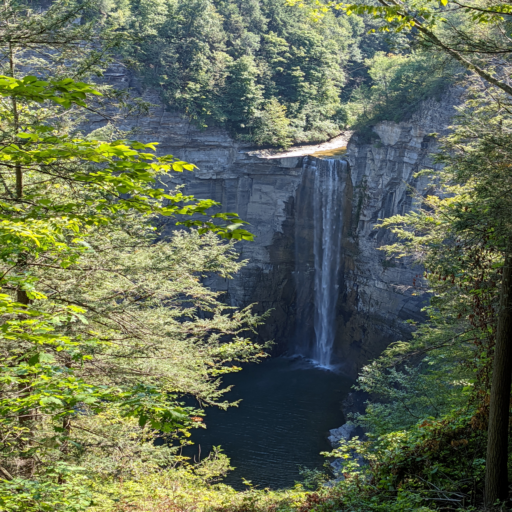

Style:


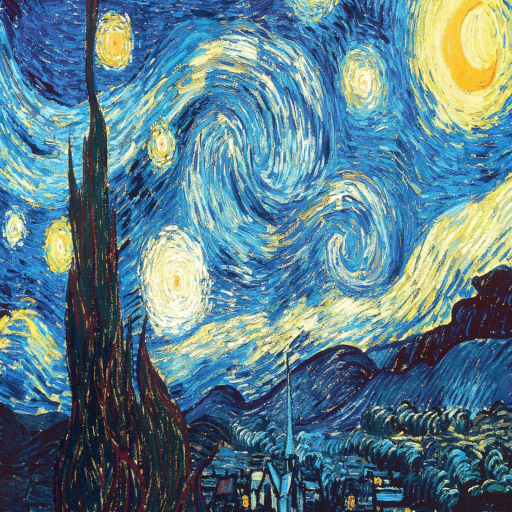

Generated:


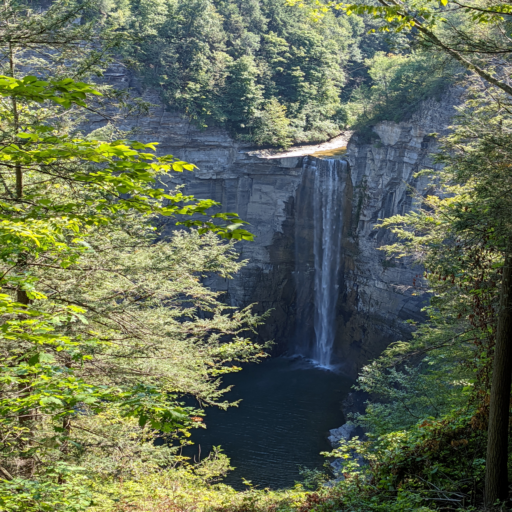

In [3]:
if torch.cuda.is_available():
    img_size = 512
    device = torch.device('cuda')
else:
    img_size = 256
    device = torch.device('cpu')

vgg_mean = torch.tensor([0.485, 0.456, 0.406])
vgg_std = torch.tensor([0.229, 0.224, 0.225])

load_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(vgg_mean, vgg_std)
])

def load_image(img_path):
    img = Image.open(img_path)

    img = load_transform(img)

    img = img.unsqueeze(0) # Add batch dimension
    return img.to(device, torch.float)

unload_transform = transforms.ToPILImage()

def unload_image(img):
    img = img.squeeze(0).to('cpu')
    # Need to swap axes/"transpose" since vgg_std is of size (3)
    img = torch.clamp(img.permute(1, 2, 0) * vgg_std + vgg_mean, 0, 1)
    # Then, swap axes back
    return unload_transform(img.permute(2, 0, 1))

content = load_image('drive/MyDrive/images/waterfall.jpg')
style = load_image('drive/MyDrive/images/starrynight.jpg')

# Original image
generated = content.clone()

# White noise
# generated = torch.randn_like(content)

print('Content:')
display(unload_image(content))
print('Style:')
display(unload_image(style))
print('Generated:')
display(unload_image(generated))


## Load the model

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # Extract from conv1_1, conv2_1, conv3_1, conv4_1, conv4_2, and conv5_1
        self.req_features = {
            0: 'conv1_1',
            5: 'conv2_1',
            10: 'conv3_1',
            19: 'conv4_1',
            21: 'conv4_2',
            28: 'conv5_1'
        }

        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

        self.model = nn.Sequential()
        for layer in model:
            if isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(2, 2)
            
            self.model.append(layer)
    
    def forward(self, x):
        features = {}
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if layer_num in self.req_features.keys():
                key = self.req_features[layer_num]
                features[key] = x
            
        return features

vgg = VGG().to(device).eval()
print(vgg)

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool2d(

# Define the loss functions
### Content Loss:
The Content Loss is calculated by finding MSELoss on the generated image $Y$
on the content image $C$. This is usually done at a later layer to ensure that higher-level features appear in both images versus in earlier layers where the features represented aren't as important.

Let $F$ be the feature maps produced by $Y$ and $P$ be the feature maps produced by $C$.
\begin{align*}
    \mathcal{L}_{content}^l = \frac{1}{2}\sum_{i,j} (F_{ij}^l - P_{ij}^l)^2
\end{align*}

### Style Loss:
The Style Loss is calculated by finding MSELoss on the Gram matrices of the generated image $Y$ and the style image $S$ at certain layers.

The Gram matrix is defined 
\begin{align*}
    G_{ij} = \sum_{k} F_{ik}^lF_{jk}^l
\end{align*}
Where $F^l$ is the set of vectorized feature maps at layer $l$, $i$ and $j$ index over the channels, and $k$ indexes over the elements of the feature maps. The Gram matrix finds the the tendency for certain features to show up simultaneously. This encodes style since it can relate objects in a scene (like a sky) with certain stylistic patterns (swirls of yellow/blue paint).

Let $G^l$ be the style representation on $Y$, and let $A^l$ be the style representation on $S$. $N^l$, $M^l$ are the number of channels, and the spatial size (height times width) of the feature maps at layer $l$.

\begin{align*}
    \mathcal{L}_{style}^l = \frac{1}{N^lM^l}\sum_{i,j} (G^l_{ij} - A^l_{ij})^2
\end{align*}
### Total Variation Loss
The Total Variation Loss punishes variation between adjacent rows and columns in the generated image. Without this loss, the images get noisey.
\begin{align*}
    \mathcal{L}^l_{variation} = \frac{1}{2}\sum_{i,j} \left[ \lvert Y^l_{i,j} - Y^l_{i+1,j} \rvert + \lvert Y^l_{i,j} - Y^l_{i,j+1} \rvert \right]
\end{align*}

## Total Loss
The Total Loss is calculated via a weighted sum of the content, style, and total variation loss.
\begin{align*}
    \mathcal{L}_{total} = \alpha\mathcal{L}_{content} + \beta\mathcal{L}_{style} + \gamma\mathcal{L}_{variation}
\end{align*}

In [5]:
def gram_matrix(X):
    N, C, H, W = X.size()

    X = X.view(N * C, H * W)

    gram = torch.mm(X, X.t())

    return gram / (C*H*W)

def style_loss(Y, S):
    _, C, H, W = S.size()

    G_Y = gram_matrix(Y)
    G_S = gram_matrix(S)

    return torch.sum((G_Y - G_S)**2)

def content_loss(Y, C):
    return torch.mean((Y - C)**2)

def total_variation_loss(Y):
    row_var = torch.mean(torch.abs((Y[:, :, 1:, :] - Y[:, :, :-1, :])))
    col_var = torch.mean(torch.abs((Y[:, :, :, 1:] - Y[:, :, :, :-1])))

    return (row_var + col_var) / 2

def loss(generated, gen, cont, sty, alpha, beta, gamma):
    Y_cont = gen[-2]
    c_loss = content_loss(cont, Y_cont)
    tv_loss = total_variation_loss(generated)

    # Only look at style layers now
    gen.pop(-2)

    s_loss = 0
    for Y, S in zip(gen, sty):
        s_loss += style_loss(Y, S)
    
    return alpha*c_loss + beta*s_loss + gamma*tv_loss


## Hyperparameters
$\alpha:$ the content loss weight \\
$\beta:$ the style loss weight \\
$\gamma:$ the total variation loss weight

In [6]:
n_epochs = 30
alpha = 1
beta = 1e4
gamma = 1e1

generated.requires_grad_(True)
content.requires_grad_(False)
style.requires_grad_(False)

optimizer = optim.LBFGS([generated])

The paper suggests taking the style from 

Epoch: 1
Loss: tensor(7576.4531, device='cuda:0', grad_fn=<AddBackward0>)
Generated Image:


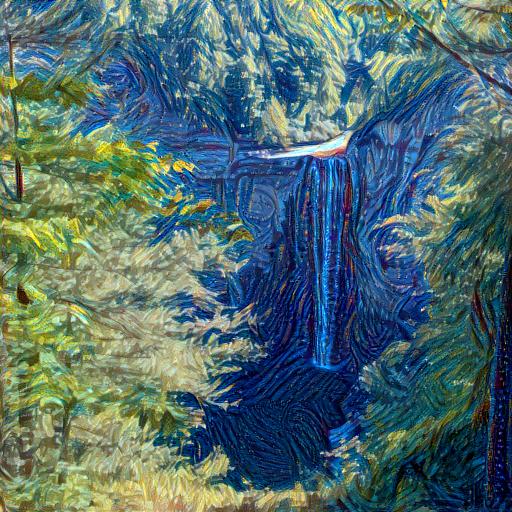

Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Loss: tensor(5.5223, device='cuda:0', grad_fn=<AddBackward0>)
Generated Image:


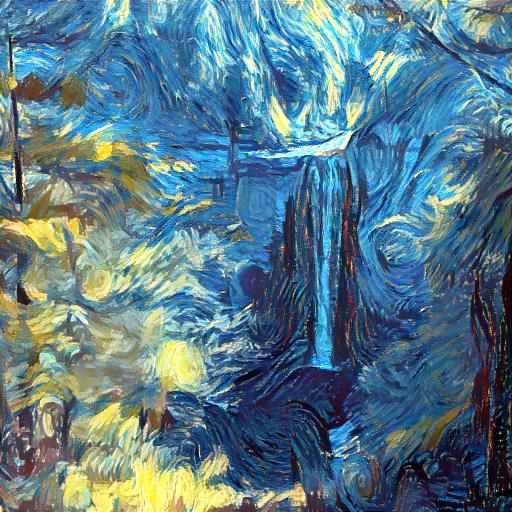

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Loss: tensor(3.9730, device='cuda:0', grad_fn=<AddBackward0>)
Generated Image:


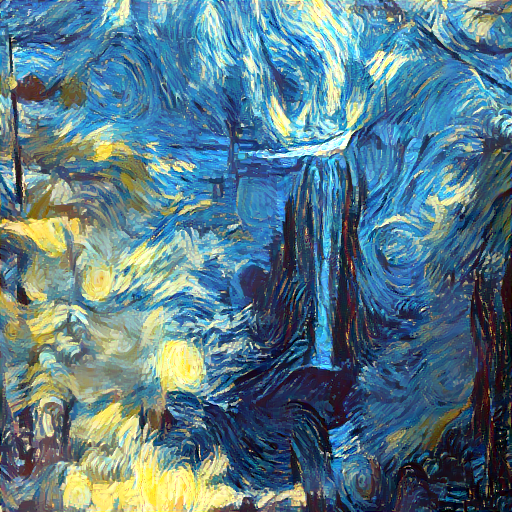

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Loss: tensor(3.6193, device='cuda:0', grad_fn=<AddBackward0>)
Generated Image:


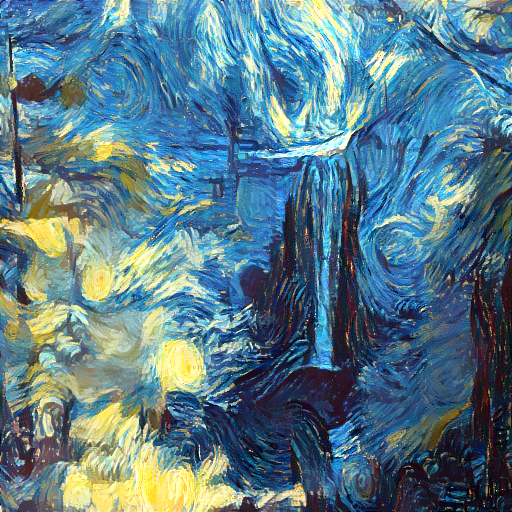

In [7]:
style_layers = [ 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1' ]
content_layer = 'conv4_2'

def closure():
    gen_features = [ vgg(generated)[key] for key in vgg.req_features.values() ]
    content_features = vgg(content)[content_layer]
    style_features = [ vgg(style)[key] for key in vgg.req_features.values() if key in style_layers ]

    total_loss = loss(
        generated, 
        gen_features, 
        content_features, 
        style_features, 
        alpha, beta, gamma
    )

    optimizer.zero_grad()

    total_loss.backward()
    return total_loss

for e in range(n_epochs):
    print('Epoch:', e + 1)
    total_loss = closure()
    optimizer.step(closure)

    if (e + 1) % 10 == 0 or e == 0:
        print('Loss:', total_loss)
        print('Generated Image:')
        display(unload_image(generated))
